In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
np.random.seed(42)

### 실험 방법
* 공통의 예측 함수를 정의
* 임의의 데이터를 생성하여 예측 함수를 학습
* 학습 과정의 최적화 함수를 비교
  
### 공통 예측 함수
* Logistic Regression
  * binary classification
  * $x \rightarrow p(y=1\mid x)$
  * 출력은 0과 1 사이의 확률
* 모델 구조
  * predict함수로 구현
  * 선형 조합: $z=w^{\top}X + b$
  * 확률 변환: $\hat{y}=\sigma(z)=\frac{1}{1+e^{-z}}$
* 손실함수
  * Binary Cross-Entropy
  * $L = -\frac{1}{m} \sum^m_{i=1}[y_i log(\hat{y}_i) + (1-y_i) log(1-\hat{y}_i) ]$
* 학습
  * 손실 함수를 w, b에 대해 미분해서 gradient 계산
  * optimizer update에 사용
  * weight: $dw = \frac{1}{m} \sum_i(\hat{y}_i - y_i)x_i$
  * bias: $db = \frac{1}{m} \sum_i(\hat{y}_i - y_i)$

In [40]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    

def predict(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)
    

def binary_cross_entropy(y_true, y_pred, eps=1e-8):
    left_hand = y_true * np.log(y_pred + eps)
    right_hand = (1- y_true) * np.log(1- y_pred + eps)
    return - np.mean(left_hand + right_hand)
    

def gradient(X, y_true, y_pred):
    m = len(y_true)
    dw = np.dot(X.T, (y_pred - y_true)) / m
    db = np.mean(y_pred - y_true)
    return dw, db
    

def visualize(losses):
    plt.figure(figsize=(6,4))
    for name, loss in losses.items():
        plt.plot(loss, label=name)
        plt.scatter(0, loss[0], marker="*", c="red")
        plt.text(0, loss[0], s=round(loss[0], 2))
        
        plt.scatter(len(loss)-1, loss[-1], marker="*", c="red")
        plt.text(len(loss)-1, loss[-1], s=round(loss[-1], 2))

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("optimizer comparison")
    plt.legend()
    plt.show()
    plt.close()

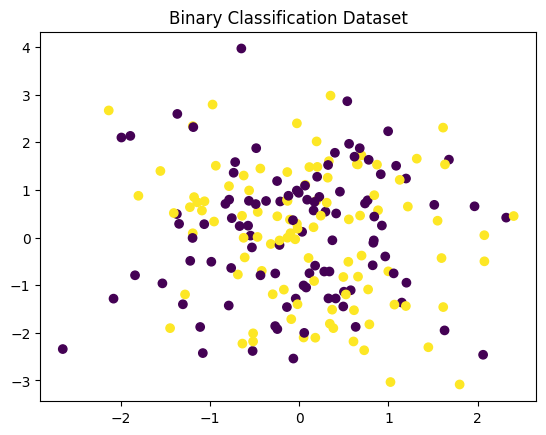

In [36]:
# common settings
n_epochs = 100
lr = 0.01
n_features = 10

# logistic regression
_w = np.random.randn(n_features, 1)
_b = np.zeros([1])

# binary classification dataset
X, y = make_classification(
    n_samples=200,
    n_features=n_features,
    n_redundant=0,
    n_informative=2,
    random_state=42
)


plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Binary Classification Dataset")
plt.show()

## 1. Stochastic Gradient Descent(SGD)

* 정의
  * 확률적 경사 하강법
    * 전체 데이터에서 일부를 확률적으로 사용해서 기울기 계산
  * 전체 데이터에서 일부의 훈련 샘플을 사용하여 gradient를 계산하고 매개 변수를 업데이트
    * 모든 데이터를 한번에 계산하기에는 메모리, 계산 시간 등의 문제가 있음
    * 일부씩 모든 데이터를 한 바퀴 쭉 사용함
  * 계산 비용을 절감, 비선형 최적화 문제에 대한 솔루션으로  **근사**
* 수식
  * $w := w - \eta \nabla_w L(w)$
  * w: 학습중인 파라미터
  * $\eta$: learning rate (학습률)
  * $L(w)$: 손실 함수
  * $\nabla_wL(w)$:w에 대한 손실의 기울기(gradient)
* 특징
  * 단순하고 빠름: 계산량이 적어서 대규모 데이터에서도 효율적
  * 노이즈: 일부의 데이터로 gradient를 구하기 떄문에 업데이트 변동이 큼
  * 학습률이 중요: 너무 크면 발산, 너무 작으면 느림

## 2. Momentum

* 정의
  * SGD의 단점: gradient의 방향이 매번 바뀌어서 진동(oscillation이 심함)
  * 이는 **수렴이 느리거나 최적점 근처에서 왔다갔다함**
  * momentum(관성)은 이전 단계의 이동 방향(속도)을 **관성**처럼 조금 더 유지해서 더 빠르고 안정적으로 수렴하게 하는 방법
* 수식
  * $w := w - \eta v_t$  
  * 속도(velocity)의 개념을 추가
    * $v_t = \beta v_{t-1} + (1-\beta)\nabla_w L(w)$
* 특징
  * 기존 **SGD에 속도**라는 개념을 추가하고 $\beta$를 통해 그 계수 조절
  * 속도는 이전 시점(t-1)의 방향을 일정 비율만큼 유지해서 현재 시점에 영향을 준다
  * 진동을 줄이고 빠르게 수렴
  * (2D곡면) x축 방향의 기울기가 작고, y축 방향으로 가파른 언덕
    * sgd는 y축 방향으로 왔다갔다 하며 느리게 내려옴
    * Momentum은 관성 때문에 x축 방향으로 조금 더 밀려가면서 매끄럽고 빠르게 수렴
* 수식 정의
  
| 기호                | 의미                    |
| ----------------- | --------------------- |
| $ w $             | 학습 중인 파라미터            |
| $ \eta $          | learning rate (학습률)   |
| $ v_t $           | 현재 단계의 “속도(velocity)” |
| $ \beta $         | 모멘텀 계수 (보통 0.9 정도)    |
| $ \nabla_w L(w) $ | 현재 손실의 기울기            |


## 3. Nesterov Accelerated Gradient(NAG)

* 정의
  * Momentum은 "이전 속도 방향(velocity)으로 이동한 후" gradient를 계산
  * 너무 많이 이동하거나 overshoot(넘침)하는 경우가 있음
  * NAG는 미리 한 발 앞서서(**look ahead**) gradient를 계산
    * 지금 이동할 위치를 미리 예상하고 그 지점에서 gradient를 계산
* 수식
  * $w := w - \eta v_t$  
  * 속도(velocity)에 다음 위치를 미리 예상해서 그 지점에서 gradient를 구한다 (look ahead)
    * $v_t = \beta v_{t-1} + (1-\beta)\nabla_w L(w - \eta \beta v_{t-1})$
* 특징
  * Look ahead: 앞으로 이동할 지점에서 gradient 계산
  * Momentum보다 overshooting(넘침) 현상이 줄어듦
  * 만약 자동차가 언덜을 내려간다
    * Momentum은 이전 속도를 그대로 유지하며 내려감
    * NAG는 다음 커브를 미리 보고 속도를 조절
* 수식 정의
  
| 기호                | 의미                    |
| ----------------- | --------------------- |
| $ w $             | 학습 중인 파라미터            |
| $ \eta $          | learning rate (학습률)   |
| $ v_t $           | 현재 단계의 속도(velocity) |
| $ \beta $         | 모멘텀 계수 (보통 0.9 정도)    |
| $ \nabla_w L(w - \eta \beta v_{t-1}) $ | '앞으로 한 발 나간' 지점에서의 gradient|


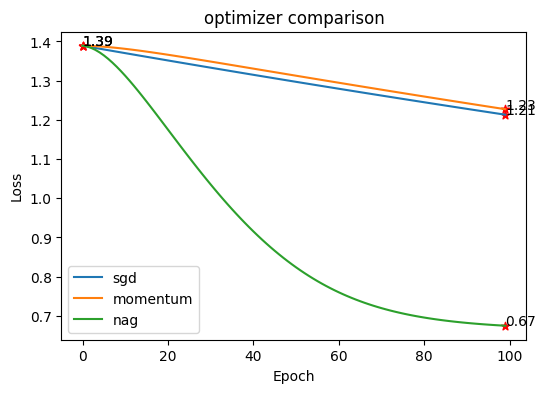

In [41]:
from src.optimizers import SGD, Momentum, NAG


optimizers = {
    SGD.name: SGD(lr),
    Momentum.name: Momentum(lr),
    NAG.name: NAG(lr)
}
losses = {}
for name, optimizer in optimizers.items():
    w = _w.copy()
    b = _b.copy()
    loss = []
    
    for epoch in range(n_epochs):
        y_pred = predict(X, w, b)
        _loss = binary_cross_entropy(y, y_pred)
        dw, db = gradient(X, y, y_pred)

        # update
        w = optimizer.update(w, dw)
        b -= lr * db
    
        loss.append(_loss)

    losses[name] = loss
visualize(losses)